In [315]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Extract features

### Single file example extraction

In [334]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield start, start + window_size
        start += (window_size // 2)

def extract_feature_array(filename, bands=21, frames=41):
    window_size = 512 * (frames-1)
    mfccs = []
    sound_clip, s = librosa.load(filename, sr=44100)
    for (start, end) in windows(sound_clip, window_size):
        start = int(start)
        end = int(end)
        if(len(sound_clip[start:end]) == window_size):
            signal = sound_clip[start:end]
            mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands)
            mfccs.append(mfcc)
#             mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands).T.flatten()[:, np.newaxis].T
#             logspec = librosa.logamplitude(melspec)
#     log_specgrams = np.expand_dims(np.asarray(log_specgrams), axis=3)
    return np.asarray(mfccs)

# # Uncomment if using deltas
#
#     log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
#     features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
#     for i in range(len(features)):
#         features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
#     return np.array(features)

# sample_filename = 'data/speech-accent-archive/recordings/afghanistan/dari2.mp3'
sample_filename = '/Users/leonmak/Documents/CS229/final-project/data/SC-scripted-word/CH/SC_W_CH_04_EN-chunk-5.wav'
features = extract_feature_array(sample_filename)
data_points, _ = librosa.load(sample_filename)
print ('IN: Initial Data Points =', len(data_points))
print ('OUT: Total features =', np.shape(features))


IN: Initial Data Points = 11907
OUT: Total features = (1, 21, 41)


# Classes

In [303]:
from sklearn import preprocessing

def iter_label_files(parent_dir):
    """Utility for extracting labels"""
    for root, dirpaths, fnames in os.walk(parent_dir):
        if len(dirpaths) > 0:
            continue
        label = root.split('/')[-1]
        yield root, label, fnames

# parent_dir = 'data/speech-accent-archive/recordings/'
parent_dir = 'data/SC-scripted-word/'
labels = []
for _, label, _ in iter_label_files(parent_dir):
    labels.append(label)
print(f'{len(labels)} labels found, First 5: {labels[:5]}')


10 labels found, First 5: ['CH', 'EN', 'IN', 'IR', 'IT']


In [332]:
cap = 240
counts = []
for _, label, fnames in iter_label_files(parent_dir):
    counts.append(len(fnames))

top_indices_count = [i_count for i_count in sorted(enumerate(counts), key=lambda x:x[1], reverse=True)]
most_freq_egs = [labels[i] for (i, count) in top_indices_count if count >= cap]
print(f'Labels with >= {cap} egs: {most_freq_egs}, len:{len(most_freq_egs)}')    

le = preprocessing.LabelEncoder()
ohe = preprocessing.OneHotEncoder()
le_ed = le.fit_transform(most_freq_egs)
ohe_ed = ohe.fit_transform(le_ed.reshape(len(le_ed), 1))
print(ohe_ed.toarray())


Labels with >= 240 egs: ['TU', 'EN', 'KO', 'CH', 'IR', 'RU', 'IN', 'IT', 'TH', 'JA'], len:10
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]]


# Save features

In [333]:
import random 
import speechpy

NUM_MFCCS = 50
DEFAULT_BITRATE = 22050
DESIRED_DURATION = 25  # seconds
PADDED_LENGTH = DEFAULT_BITRATE * DESIRED_DURATION


def get_label_enc(fn, le):
    fn_parts = fn.split('/')
    label_txt = fn_parts[-2]  # y_i
    label_int = le.transform([label_txt])
    return label_int[0]


def normalize_audio(source_files):
    fixed_lengths = [librosa.util.fix_length(y, PADDED_LENGTH) for y, _ in source_files]
    return [(f - np.mean(f)) / np.std(f) for f in fixed_lengths]


def load_audio(source_files):
    loaded_mp3_files = [librosa.load(f) for f in source_files]
    fix_length_mp3 = normalize_audio(loaded_mp3_files)
    mfccs = [librosa.feature.mfcc(y=y, sr=DEFAULT_BITRATE, n_mfcc=NUM_MFCCS) for y in fix_length_mp3]
    return mfccs


def get_labels(fnames):
    labels = [get_label_enc(fn, le) for fn in fnames]
    return labels


def extract_feature(fnames):
    """
    Extract features from filenames to features and labels arrays
    """
    mfccs = load_audio(fnames)
    labels = get_labels(fnames)
    return np.asarray(mfccs), np.asarray(labels)
#     window_size = 512 * (frames-1)
#     log_specgrams = []
#     mfccs = []
#     labels = []
#     for fn in fnames:
#         sound_clip, s = librosa.load(fn)
# #         sound_clip -= np.mean(sound_clip)
# #         sound_clip /= max(sound_clip)
#         label_enc = get_label_enc(fn, le)
#         for (start, end) in windows(sound_clip, window_size):
#             signal = sound_clip[start:end]
#             if(len(signal) != window_size):
#                 break
#             labels.append(label_enc)
# #             melspec = librosa.feature.mfcc(signal, sr=s, n_mels=bands)
# #             logspec = librosa.logamplitude(melspec)
# #             log_specgrams.append(logspec)
#             mfcc = librosa.feature.mfcc(signal, sr=s, n_mfcc=bands)
#             mfccs.append(mfcc)
#     if word == False:
#         log_specgrams = np.expand_dims(np.asarray(log_specgrams), axis=3)
#     return np.asarray(mfccs), np.asarray(labels, dtype='int')
#     log_specgrams = np.array(log_specgrams).reshape(len(log_specgrams),bands,frames,2)
#     features = np.concatenate((log_specgrams, np.zeros(log_specgrams.shape)), axis=3)
#     for i in range(len(features)):
#         features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
#     return np.array(features), np.array(labels, dtype='int')


def get_subset_fnames():
    subset_fnames = []
    for root, label, fnames in iter_label_files(parent_dir):
        if label not in most_freq_egs:
            continue
        for fn in fnames[:cap]:
            if '.DS_Store' in fn:
                continue
            subset_fnames.append(os.path.join(root, fn))
    random.seed(24)
    random.shuffle(subset_fnames)
    return subset_fnames


def save_folds(save_dir, num_folds=10, fold_prefix='fold_orig_w'):
    fnames = get_subset_fnames()
    egs_per_fold = len(fnames) // num_folds
    curr = 0
    features = []
    labels = []
    for k in range(num_folds):
        fold_name = f'{fold_prefix}{str(k)}'
        
        feature_file = os.path.join(save_dir, fold_name + '_x.npy')
        labels_file = os.path.join(save_dir, fold_name + '_y.npy')

        print(f'Saving feature_file {feature_file} \nSaving labels_file {labels_file}')
        start_i = k * egs_per_fold
        end_i = (k + 1) * egs_per_fold
        fnames_fold = fnames[start_i: end_i]
        features, labels = extract_feature(fnames_fold)
#         features = np.concatenate([features, new_features]) if len(features) > 0 else np.asarray(new_features)
#         labels = np.concatenate([labels, new_labels]) if len(labels) > 0 else np.asarray(new_labels)
        print(f'Features of {fold_name} = {features.shape}')
        print(f'Labels of {fold_name} = {labels.shape}')

        np.save(feature_file, features)
        np.save(labels_file, labels)


save_dir=os.path.join('npy', 'mfcc_w')
save_folds(save_dir)


Saving feature_file npy/spec/fold_orig_w0_x.npy 
Saving labels_file npy/spec/fold_orig_w0_y.npy
Features of fold_orig_w0 = (239, 50, 1077)
Labels of fold_orig_w0 = (239,)
Saving feature_file npy/spec/fold_orig_w1_x.npy 
Saving labels_file npy/spec/fold_orig_w1_y.npy
Features of fold_orig_w1 = (239, 50, 1077)
Labels of fold_orig_w1 = (239,)
Saving feature_file npy/spec/fold_orig_w2_x.npy 
Saving labels_file npy/spec/fold_orig_w2_y.npy
Features of fold_orig_w2 = (239, 50, 1077)
Labels of fold_orig_w2 = (239,)
Saving feature_file npy/spec/fold_orig_w3_x.npy 
Saving labels_file npy/spec/fold_orig_w3_y.npy
Features of fold_orig_w3 = (239, 50, 1077)
Labels of fold_orig_w3 = (239,)
Saving feature_file npy/spec/fold_orig_w4_x.npy 
Saving labels_file npy/spec/fold_orig_w4_y.npy
Features of fold_orig_w4 = (239, 50, 1077)
Labels of fold_orig_w4 = (239,)
Saving feature_file npy/spec/fold_orig_w5_x.npy 
Saving labels_file npy/spec/fold_orig_w5_y.npy
Features of fold_orig_w5 = (239, 50, 1077)
Labels

# Load Features

In [335]:
from keras.utils import to_categorical
data_dir = os.path.join('npy', 'mfcc_w')
print(data_dir)
fold_prefix = 'fold_orig_w'

def add_folds(data_dir):
    files_lst = os.listdir(data_dir)
    num_folds = len(list(filter(lambda k: fold_prefix in k, files_lst))) // 2
        
    for k in range(num_folds-3):
        fold_name = f'{fold_prefix}{str(k)}'
        print("\nAdding " + fold_name)
        feature_file = os.path.join(data_dir, fold_name + '_x.npy')
        labels_file = os.path.join(data_dir, fold_name + '_y.npy')
        loaded_features = np.load(feature_file)
        loaded_labels = np.load(labels_file)
        print("New Features: ", loaded_features.shape, loaded_labels.shape)
        if k > 0:
            features = np.concatenate((features, loaded_features))
            labels = np.concatenate((labels, loaded_labels))
        else:
            features = loaded_features
            labels = loaded_labels
    return features, labels

train_x, train_y = add_folds(data_dir)

# use a fold for train-dev
valid_fold_name = f'{fold_prefix}7'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
train_dev_x = np.load(feature_file)
train_dev_y = np.load(labels_file) 

# use a fold for dev
valid_fold_name = f'{fold_prefix}8'
feature_file = os.path.join(data_dir, valid_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, valid_fold_name + '_y.npy')
dev_x = np.load(feature_file)
dev_y = np.load(labels_file) 

# and a fold for testing
test_fold_name = f'{fold_prefix}9'
feature_file = os.path.join(data_dir, test_fold_name + '_x.npy')
labels_file = os.path.join(data_dir, test_fold_name + '_y.npy')
test_x = np.load(feature_file)
test_y = np.load(labels_file)


# encode
train_y = to_categorical(train_y)
train_dev_y = to_categorical(train_dev_y)
dev_y = to_categorical(dev_y)
test_y = to_categorical(test_y)

# train_x = np.expand_dims(np.asarray(train_x), axis=3)
# train_dev_x = np.expand_dims(np.asarray(train_dev_x), axis=3)
# dev_x = np.expand_dims(np.asarray(dev_x), axis=3)
# test_x = np.expand_dims(np.asarray(test_x), axis=3)

# trim data
# last = min([len(train_x), len(train_dev_x), len(dev_x), len(test_x)])
# train_dev_x, train_dev_y = train_dev_x, train_dev_y
# dev_x, dev_y = dev_x[:last], dev_y[:last]
# test_x, test_y = test_x[:last], test_y[:last]

print(f"\nTraining Set: {train_x.shape}, Labels: {train_y.shape}")
print(f"Train-dev Set: {train_dev_x.shape}, Labels: {train_dev_y.shape}")
print(f"Dev Set: {dev_x.shape}, Labels: {dev_y.shape}")
print(f"Test Set: {test_x.shape}, Labels: {test_y.shape}")


npy/spec

Adding fold_orig_w0
New Features:  (239, 50, 1077) (239,)

Adding fold_orig_w1
New Features:  (239, 50, 1077) (239,)

Adding fold_orig_w2
New Features:  (239, 50, 1077) (239,)

Adding fold_orig_w3
New Features:  (239, 50, 1077) (239,)

Adding fold_orig_w4
New Features:  (239, 50, 1077) (239,)

Adding fold_orig_w5
New Features:  (239, 50, 1077) (239,)

Adding fold_orig_w6
New Features:  (239, 50, 1077) (239,)

Training Set: (1673, 50, 1077), Labels: (1673, 10)
Train-dev Set: (239, 50, 1077), Labels: (239, 10)
Dev Set: (239, 50, 1077), Labels: (239, 10)
Test Set: (239, 50, 1077), Labels: (239, 10)


In [340]:
tf.set_random_seed(0)
np.random.seed(0)

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D, MaxPool1D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping
from keras.metrics import categorical_accuracy
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from keras.regularizers import l2
from keras.utils import np_utils
from librosa.util import fix_length

bands = 50
frames = 1077
feature_size = bands * frames
num_labels = len(most_freq_egs)
input_shape = (bands, frames)
# input_shape=(bands, frames, num_channels) # if have delta num_channels = 1


def build_model():
    model = Sequential()
    f_size = 3
    model.add(Conv1D(128, f_size, activation='relu', input_shape=(50, 1077)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(64, f_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
    model.add(Conv1D(24, f_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
#     model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(124, activation='relu', kernel_regularizer=l2(0.001)))
#     model.add(Dropout(0.5))
    model.add(Dense(num_labels, activation='softmax', kernel_regularizer=l2(0.001)))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    return model
print("Building model...")
model = build_model()
model.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_211 (Conv1D)          (None, 48, 128)           413696    
_________________________________________________________________
batch_normalization_162 (Bat (None, 48, 128)           512       
_________________________________________________________________
max_pooling1d_154 (MaxPoolin (None, 24, 128)           0         
_________________________________________________________________
conv1d_212 (Conv1D)          (None, 22, 64)            24640     
_________________________________________________________________
batch_normalization_163 (Bat (None, 22, 64)            256       
_________________________________________________________________
max_pooling1d_155 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
conv1d_213 (Conv1D)          (None, 9, 24)             463

In [341]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(np.concatenate([train_x, train_dev_x]), 
                    np.concatenate([train_y, train_dev_y]), 
                    validation_data=(dev_x, dev_y), 
                    callbacks=[earlystop], 
                    epochs=30)

Training model...
Train on 1912 samples, validate on 239 samples
Epoch 1/30
1912/1912 [==============================] - 12s 6ms/step - loss: 1.7399 - acc: 0.4650 - val_loss: 1.4100 - val_acc: 0.5356
Epoch 2/30
1912/1912 [==============================] - 7s 4ms/step - loss: 0.6619 - acc: 0.8536 - val_loss: 0.7748 - val_acc: 0.8201
Epoch 3/30
1912/1912 [==============================] - 8s 4ms/step - loss: 0.3704 - acc: 0.9446 - val_loss: 0.5727 - val_acc: 0.8745
Epoch 4/30
1912/1912 [==============================] - 8s 4ms/step - loss: 0.2471 - acc: 0.9754 - val_loss: 0.4831 - val_acc: 0.8954
Epoch 5/30
1912/1912 [==============================] - 9s 5ms/step - loss: 0.1837 - acc: 0.9922 - val_loss: 0.4689 - val_acc: 0.9038
Epoch 6/30
1912/1912 [==============================] - 8s 4ms/step - loss: 0.1542 - acc: 0.9979 - val_loss: 0.4522 - val_acc: 0.9121
Epoch 7/30
1912/1912 [==============================] - 9s 4ms/step - loss: 0.1413 - acc: 0.9979 - val_loss: 0.3684 - val_acc: 0.9

# K-fold cross validation

In [345]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

num_splits=3
cnn_estimator = KerasClassifier(build_fn=build_model, epochs=15, batch_size=50, verbose=1)
kfold = KFold(n_splits=num_splits, shuffle=True, random_state=1)
results = cross_val_score(cnn_estimator, train_x, train_y, cv=kfold)
print("{num_splits}-fold xval accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/15
1115/1115 [==============================] - 9s 8ms/step - loss: 2.1599 - acc: 0.3399
Epoch 2/15
1115/1115 [==============================] - 4s 3ms/step - loss: 1.1187 - acc: 0.7130
Epoch 3/15
1115/1115 [==============================] - 4s 3ms/step - loss: 0.6938 - acc: 0.8610
Epoch 4/15
1115/1115 [==============================] - 4s 3ms/step - loss: 0.4259 - acc: 0.9417
Epoch 5/15
1115/1115 [==============================] - 4s 3ms/step - loss: 0.2891 - acc: 0.9803
Epoch 6/15
1115/1115 [==============================] - 4s 3ms/step - loss: 0.2190 - acc: 0.9928
Epoch 7/15
1115/1115 [==============================] - 4s 3ms/step - loss: 0.1817 - acc: 0.9982
Epoch 8/15
1115/1115 [==============================] - 4s 4ms/step - loss: 0.1567 - acc: 0.9991
Epoch 9/15
1115/1115 [==============================] - 4s 4ms/step - loss: 0.1480 - acc: 0.9991
Epoch 10/15
1115/1115 [==============================] - 4s 3ms/step - loss: 0.1473 - acc: 0.9982
Epoch 11/15
1115/1115 [======

## Examine Predictions

In [353]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x)
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(model)


Evaluating model...
[[  4.97560950e-06   6.19129883e-03   1.09320797e-06 ...,   1.57773800e-04
    1.64405545e-04   6.86315889e-06]
 [  7.38970584e-06   3.76644864e-04   8.85249319e-05 ...,   1.11912828e-04
    1.13285052e-04   3.73140443e-04]
 [  1.84767487e-05   8.55115868e-05   9.41679988e-04 ...,   1.04707306e-05
    9.40595329e-01   8.12888960e-04]
 ..., 
 [  3.04062269e-07   1.20413955e-03   4.65914811e-04 ...,   1.84291144e-04
    4.56557813e-04   1.58156963e-05]
 [  8.39205683e-08   1.28818611e-09   8.22567543e-08 ...,   1.05563629e-06
    1.18132160e-09   9.99997139e-01]
 [  2.39594956e-04   1.32804751e-04   1.23679201e-04 ...,   1.29803270e-01
    2.14800821e-04   2.40565714e-04]]
pred: [6 4 8 3 8 1 2 7 9 3 6 1 5 0 8 2 1 9 4 7 8 1 6 7 1 6 1 1 9 0 9 4 6 3 5 5 4
 0 4 8 5 4 7 5 4 4 8 4 4 0 6 3 2 2 0 2 7 5 8 6 3 3 1 7 4 4 7 1 4 2 3 4 5 7
 2 3 2 9 3 1 5 1 4 6 7 6 4 9 8 8 8 1 8 1 1 3 1 5 7 3]
test: [6 4 8 3 8 1 2 9 9 3 6 1 5 0 8 2 1 9 4 7 8 9 6 7 9 6 1 1 9 6 9 3 6 3 5 5 4
 0 4 8 5 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


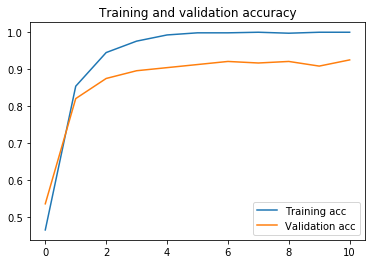

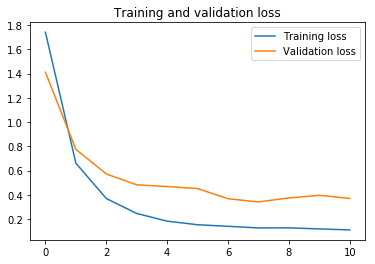

In [344]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# RNN

In [358]:


def rnn_model():        
    model = Sequential()
    model.add(LSTM(32, input_shape=(50, 1077), 
                   recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(32, recurrent_dropout=0.3, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(24, recurrent_dropout=0.3, kernel_regularizer=l2(0.001)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.3))
    model.add(Dense(num_labels, activation='softmax'))
    model.compile(optimizer=Adam(lr=0.0000002), loss='categorical_crossentropy', metrics=['acc'])
    return model

print("Building model...")
model = build_model()
model.summary()


Building model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_239 (Conv1D)          (None, 48, 128)           413696    
_________________________________________________________________
batch_normalization_190 (Bat (None, 48, 128)           512       
_________________________________________________________________
max_pooling1d_178 (MaxPoolin (None, 24, 128)           0         
_________________________________________________________________
conv1d_240 (Conv1D)          (None, 22, 64)            24640     
_________________________________________________________________
batch_normalization_191 (Bat (None, 22, 64)            256       
_________________________________________________________________
max_pooling1d_179 (MaxPoolin (None, 11, 64)            0         
_________________________________________________________________
conv1d_241 (Conv1D)          (None, 9, 24)             463

In [359]:
print("Training model...")
earlystop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')
history = model.fit(np.concatenate([train_x, train_dev_x]), 
                    np.concatenate([train_y, train_dev_y]), 
                    validation_data=(dev_x, dev_y), 
                    callbacks=[earlystop], 
                    epochs=29)

Training model...
Train on 1912 samples, validate on 239 samples
Epoch 1/29
1912/1912 [==============================] - 14s 7ms/step - loss: 1.7214 - acc: 0.4759 - val_loss: 1.5197 - val_acc: 0.5230
Epoch 2/29
1912/1912 [==============================] - 8s 4ms/step - loss: 0.6882 - acc: 0.8504 - val_loss: 0.8473 - val_acc: 0.7782
Epoch 3/29
1912/1912 [==============================] - 8s 4ms/step - loss: 0.3729 - acc: 0.9351 - val_loss: 0.6005 - val_acc: 0.8577
Epoch 4/29
1912/1912 [==============================] - 8s 4ms/step - loss: 0.2438 - acc: 0.9827 - val_loss: 0.4880 - val_acc: 0.8828
Epoch 5/29
1912/1912 [==============================] - 8s 4ms/step - loss: 0.1949 - acc: 0.9869 - val_loss: 0.3875 - val_acc: 0.9205
Epoch 6/29
1912/1912 [==============================] - 8s 4ms/step - loss: 0.1610 - acc: 0.9958 - val_loss: 0.3596 - val_acc: 0.9205
Epoch 7/29
1912/1912 [==============================] - 8s 4ms/step - loss: 0.1424 - acc: 0.9984 - val_loss: 0.2808 - val_acc: 0.9

In [356]:
from sklearn.metrics import roc_auc_score

def evaluate(model):
    y_prob = model.predict_proba(test_x, verbose=0)
    print(y_prob)
    y_pred = model.predict(test_x)
    print(f'pred: {np.argmax(y_pred[:100],axis=1)}')
    y_true = np.argmax(test_y)
    print(f'test: {np.argmax(test_y[:100],axis=1)}')

    # evaluate the model
    score, accuracy = model.evaluate(test_x, test_y)
    print("Accuracy = {:.2f}".format(accuracy))
    
    return accuracy

# now evaluate the trained model against the unseen test data
print("Evaluating model...")
acc = evaluate(model)


Evaluating model...
[[  8.57335453e-06   1.26271174e-04   7.73236835e-08 ...,   2.48898431e-07
    2.43906629e-06   2.31884574e-08]
 [  3.97547556e-04   7.33589161e-07   6.06043045e-07 ...,   2.70422424e-05
    3.78817560e-07   3.40834231e-05]
 [  6.61775573e-07   7.95124890e-07   5.94827770e-06 ...,   3.40848010e-06
    9.98017192e-01   4.27280747e-06]
 ..., 
 [  3.19472605e-07   2.35827011e-03   7.14227965e-04 ...,   2.26165153e-04
    6.81586424e-03   7.31445743e-06]
 [  1.41657621e-03   1.61778217e-08   2.98832568e-08 ...,   1.29372987e-03
    2.93935809e-09   9.92053509e-01]
 [  2.17855215e-01   2.18488003e-05   1.35718778e-06 ...,   1.73070075e-04
    3.22754227e-06   3.99324272e-05]]
pred: [6 4 8 4 8 1 2 4 9 3 6 1 5 0 3 2 1 9 4 7 3 0 6 7 4 6 1 1 9 4 9 4 6 3 5 5 4
 0 4 8 5 4 4 4 4 8 4 4 4 0 3 3 1 2 0 2 7 5 6 6 3 3 1 7 4 4 4 1 4 2 3 4 5 7
 2 3 2 9 3 1 6 1 4 6 6 7 4 9 8 0 8 1 8 1 1 3 1 5 5 2]
test: [6 4 8 3 8 1 2 9 9 3 6 1 5 0 8 2 1 9 4 7 8 9 6 7 9 6 1 1 9 6 9 3 6 3 5 5 4
 0 4 8 5 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


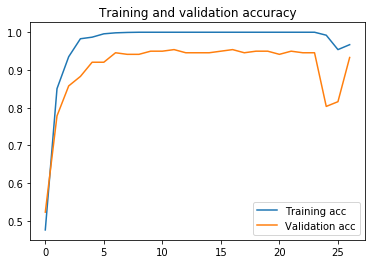

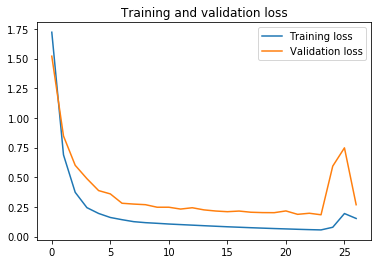

In [360]:
# import matplotlib.pyplot as plt
print(history.history.keys())
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()